In [1]:
import os
os.environ['R_HOME'] = '/root/miniconda3/envs/R4.0.3/lib/R'
os.environ['R_USER'] = '/root/miniconda3/lib/python3.8/site-packages/rpy2'
import scanpy as sc
import pandas as pd
import numpy as np
import stHGCL

2026-01-15 21:30:18.107389: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-15 21:30:18.238100: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-15 21:30:18.902448: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2026-01-15 21:30:18.902509: W tensorflow/

In [2]:
Batch_list = []
adj_list = []
section_id = ['151669','151670','151671','151672']
print(section_id)
for section_id in section_id:
    print(section_id)
    input_dir = os.path.join('/root/autodl-tmp/', section_id)
    adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join="++")
    # read the annotation
    Ann_df = pd.read_csv(os.path.join(input_dir,'metadata.tsv'), sep='\t')
    Ann_df[Ann_df['layer_guess'].isna()] = "unknown"############################################
    adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'layer_guess'].astype('category')
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]
    Batch_list.append(adata)

['151669', '151670', '151671', '151672']
151669
151670
151671
151672


In [3]:
import anndata as ad
batch_name = ['batch1','batch2','batch3','batch4']
adata_concat = ad.concat(Batch_list, label="slice_name",keys = batch_name)
adata_concat.obs['Ground Truth'] = adata_concat.obs['Ground Truth'].astype('category')
adata_concat.obs["batch"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (15284, 33538)


In [4]:
adata_batch = stHGCL.preprocess(adata_concat ,min_cells=50, min_counts=10, pca_n_comps=200,hight_var = 3000,Resolution = 'spot')

AnnData object with n_obs × n_vars = 15284 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'slice_name', 'batch', 'n_counts', 'sz_factor'
    var: 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'gs_factor'
    uns: 'hvg', 'log1p'
    obsm: 'spatial', 'X_', 'p_counts'
    layers: 'count'


In [5]:
n_clust = 5
adata_integrate = stHGCL.stHGCL_multi(adata_batch, batch_name,Batch_list)
adata_integrate = stHGCL.mclust_R(adata_integrate, used_obsm='feat', n_clusters=n_clust)
y_pred_m = np.array(adata_integrate.obs['mclust'])

Graph construction is done...
Start training on cuda...
Train with stHGCL...


100%|██████████| 800/800 [01:51<00:00,  7.15it/s]


Train with MNN


0it [00:00, ?it/s]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


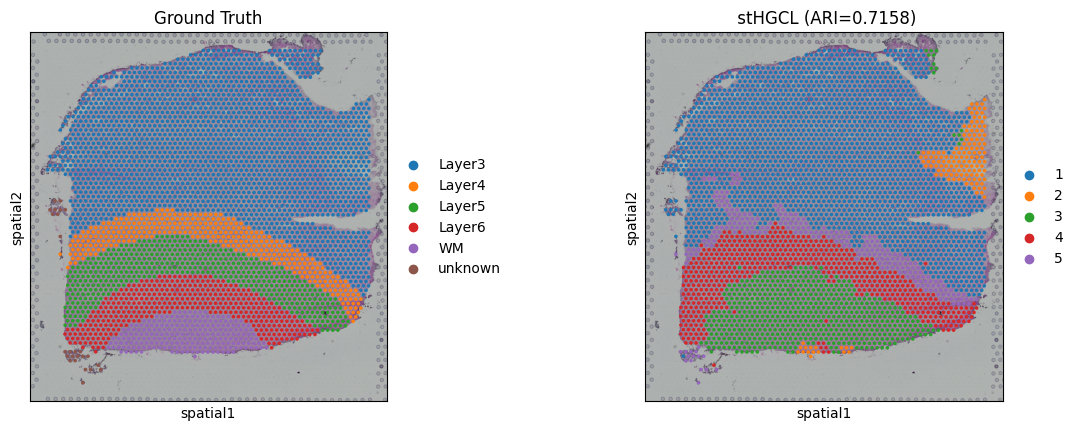

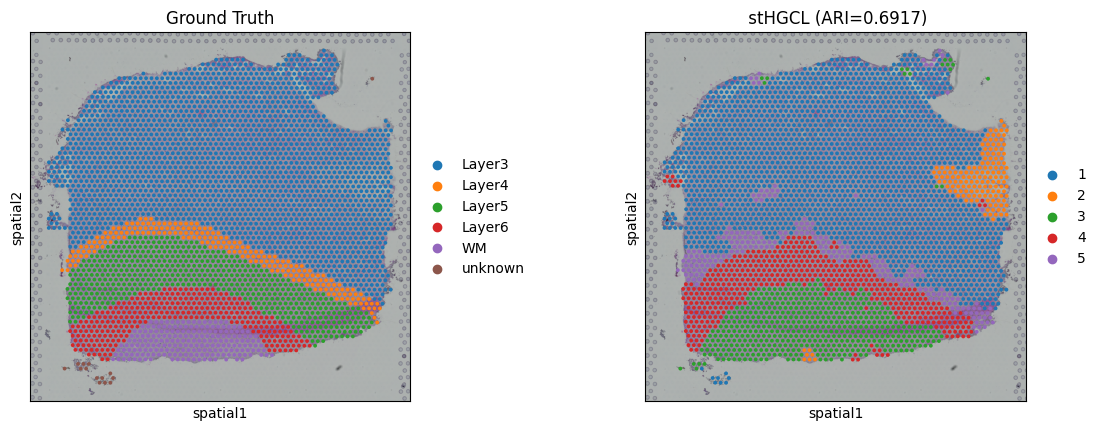

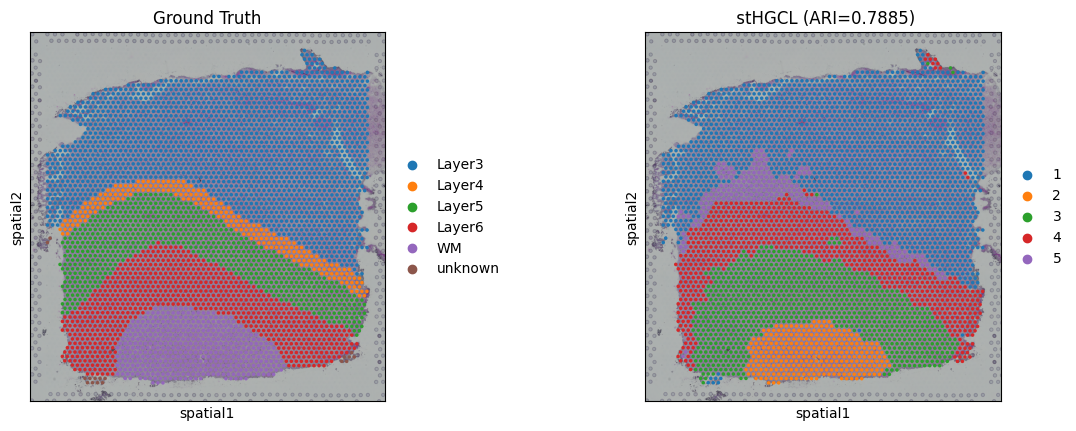

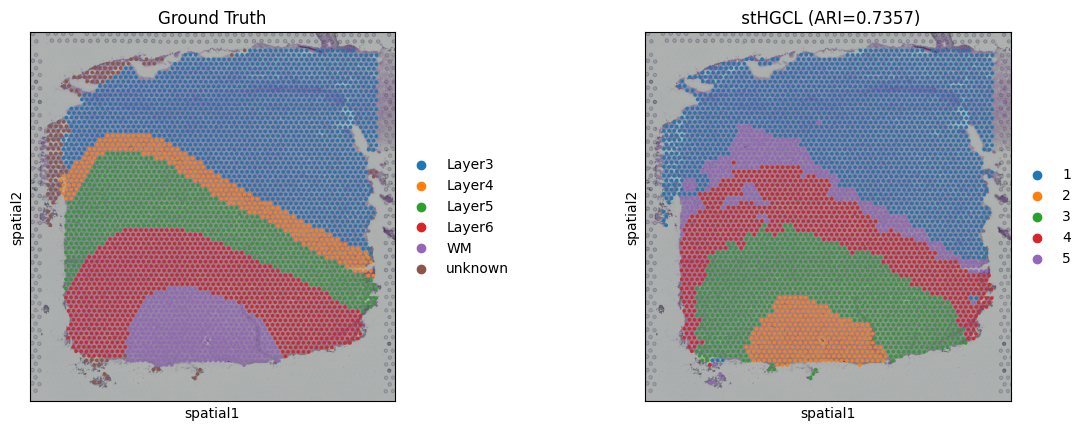

In [6]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score,silhouette_score, adjusted_mutual_info_score, davies_bouldin_score, calinski_harabasz_score
Batch_list_adj = []
adata = adata_integrate
for i in range(4):
    Batch_list_adj.append(Batch_list[i].uns['spatial'])
ARI_list = []
Batch_list_= []
batch_ids= ['batch1', 'batch2', 'batch3', 'batch4']
for batch_id in batch_ids:
    Batch_list_.append(adata[adata.obs['batch'] == batch_id])
for bb in range(4):
    ARI_list.append(adjusted_rand_score(Batch_list_[bb].obs['Ground Truth'], Batch_list_[bb].obs['mclust']))
    Batch_list_[bb].uns['spatial'] = Batch_list_adj[bb]
    sc.pl.spatial(Batch_list_[bb],
              img_key="hires",
              color=['Ground Truth', "mclust"],
              title=['Ground Truth', " stHGCL (ARI=%.4f)" % (ARI_list[bb])],
              show=False)